In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from kernel_learning import *
from src.sqw import SpecNeuralRepr
from src.kernel import L_Kernel
torch.set_default_dtype(torch.float32)

Train kernel net and background net

In [3]:
data_path = '/pscratch/sd/y/yn754/data/S2e/summarized_neutron_data_w_bkg_260meV_ML.pt'
checkpoint_dir = '/pscratch/sd/y/yn754/data/S2e/checkpoints/'
SpecNeuralRepr_ckpt = '/pscratch/sd/y/yn754/data/S2e/input/version_14896845/checkpoints/epoch=7160-step=343728.ckpt' #checkpoint for forward model

# Load and preprocess data
data_dict = load_data(data_path)
hklw_grid, interior_points = preprocess_data(data_dict)

model_sqw = SpecNeuralRepr()
model_sqw.params = torch.tensor([29, 1.7])

#Configurations
config = {'model_config': {'dim': 4,
                     'neighbor_range': 1,
                     'exclude_corner': True,
                     'hidden_dim': 256,
                     'num_layers': 3,
                     'scale_factor_initial': 300.,
                 }
    }

# Prepare dataset and dataloader
dataset = NeighborDataset(hklw_grid, data_dict['S'], neighbor_range= config['model_config']['neighbor_range'])
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Train model
kernel_model = L_Kernel(forward_model=model_sqw, model_config = config['model_config']).to(model_sqw.device)
train_model(kernel_model, dataloader,max_epochs=50, limit_train_batches = 1000,checkpoint_dir=checkpoint_dir,save_best=False)

/pscratch/sd/y/yn754/envs/S2e/lib/python3.13/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /pscratch/sd/y/yn754/envs/S2e/lib/python3.13/site-pa ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/pscratch/sd/y/yn754/envs/S2e/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by de

Epoch 49: 100%|██████████| 1000/1000 [00:10<00:00, 94.20it/s, v_num=0, train_reconst=4.360, train_bkg_mag=0.633, train_loss=4.990]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1000/1000 [00:10<00:00, 93.78it/s, v_num=0, train_reconst=4.360, train_bkg_mag=0.633, train_loss=4.990]


Test

In [5]:
from src.data_utils import get_neighbors
import numpy as np
from scipy.ndimage import binary_erosion
from src.qpath import linspace_2D_equidistant
import matplotlib.pyplot as plt
from src.data_utils import get_neighbors, func_index_tensor
# from src.siren import SirenNet
# from src.dataset import NeighborDataset
# from torch.utils.data import DataLoader

In [8]:
### load data and forward model##########
data_path = '/pscratch/sd/y/yn754/data/S2e/summarized_neutron_data_w_bkg_260meV_ML.pt'

### old training########################
best_ckpt = '/pscratch/sd/y/yn754/data/S2e/input/version_14896845/checkpoints/epoch=7160-step=343728.ckpt' #checkpoint for forward model
model_sqw0 = load_trained_model(best_ckpt) #specify forward model
model_sqw0.params = torch.tensor([29, 1.7])
#########################################

### load from new checkpoint ##########
#checkpoint_dir = '/global/homes/y/yn754/kernel-s2e/lightning_logs/version_24/checkpoints/'
checkpoint_dir = '/pscratch/sd/y/yn754/data/S2e/checkpoints/lightning_logs/version_0/checkpoints/'
ckpt_path = checkpoint_dir + 'epoch=49-step=50000.ckpt'
#######################################

model_sqw = SpecNeuralRepr()
model_sqw.params = torch.tensor([29, 1.7])
model = L_Kernel.load_from_checkpoint(ckpt_path,forward_model = model_sqw )
model_sqw = model.forward_model 
model_sqw.params

model_config = torch.load(ckpt_path)['hyper_parameters']['model_config']


/tmp/ipykernel_26129/878424049.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_config = torch.load(ckpt_path)['hyper_parameters']['model_config']


In [9]:
model_config

{'dim': 4,
 'neighbor_range': 1,
 'exclude_corner': True,
 'hidden_dim': 256,
 'num_layers': 3,
 'scale_factor_initial': 300.0}

In [10]:
#load data
data_dict = torch.load('/pscratch/sd/y/yn754/data/S2e/summarized_neutron_data_w_bkg_260meV_ML.pt',weights_only=False)
print(data_dict.keys())

dict_keys(['grid', 'S', 'background', 'background_dict'])


In [11]:
data_dict['grid']['l_grid']

tensor([-10.0000,  -9.5000,  -9.0000,  -8.5000,  -8.0000,  -7.5000,  -7.0000,
         -6.5000,  -6.0000,  -5.5000,  -5.0000,  -4.5000,  -4.0000,  -3.5000,
         -3.0000,  -2.5000,  -2.0000,  -1.5000,  -1.0000,  -0.5000,   0.0000,
          0.5000,   1.0000,   1.5000,   2.0000,   2.5000,   3.0000,   3.5000,
          4.0000,   4.5000], dtype=torch.float64)

In [12]:
hklw_grid = torch.vstack([_.unsqueeze(0) for _ in torch.meshgrid(*[v for k, v in data_dict['grid'].items()], indexing='ij')]).permute(1, 2, 3, 4, 0)
kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = data_dict['grid']['w_grid']

_l = data_dict['grid']['l_grid'][0]

params = torch.tensor([29, 1.7])

x_input = torch.zeros(wpts.shape[0], kpts.shape[0], 6)
x_input[...,:4] = torch.cat([
    kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
    _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
    wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
   ], dim=2)
x_input[...,4:] = params

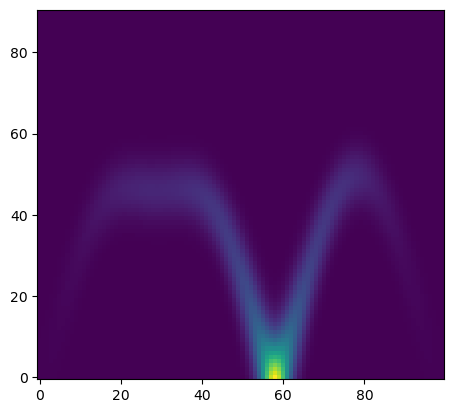

In [13]:
#best from previous training
S_pred = model_sqw0.forward_qwp(x_input.to(model_sqw0.device)).detach().cpu().numpy()

plt.imshow(S_pred, origin='lower')

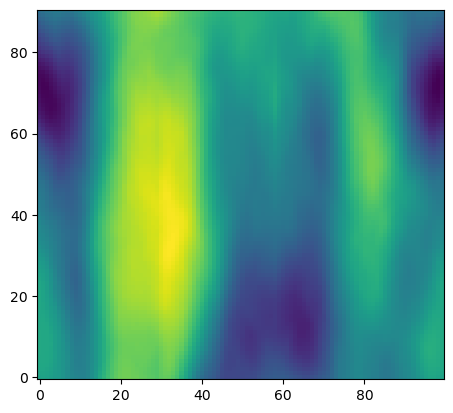

In [14]:
#current
S_pred = model_sqw.forward_qwp(x_input.to(model_sqw0.device)).detach().cpu().numpy()

plt.imshow(S_pred, origin='lower')

Evaluate

In [15]:
idx_centers = torch.from_numpy(interior_points[:2])
idx_neighbs, _ = get_neighbors(idx_centers, dim=model_config['dim'], neighbor_range=model_config['neighbor_range'], return_flat=False, exclude_corner=True)
q_centers = func_index_tensor(hklw_grid, idx_centers)
q_neighbs = func_index_tensor(hklw_grid, idx_neighbs)

In [16]:
device = model_sqw.device
dtype = model_sqw.dtype

kernel_net = model.kernel_net
kernel_net.to(device).to(dtype)

KernelNet(
  (kernel_net): Sequential(
    (0): SirenNet(
      (layers): ModuleList(
        (0-2): 3 x Siren(
          (activation): Sine()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (last_layer): Siren(
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=65, bias=True)
    (4): Softmax(dim=-1)
  )
  (sf_net): Sequential(
    (0): SirenNet(
      (layers): ModuleList(
        (0-2): 3 x Siren(
          (activation): Sine()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (last_layer): Siren(
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=65, bias=True)
    (4): ReLU()
  )
)

In [17]:
kernel_net(func_index_tensor(hklw_grid, idx_neighbs).to(model_sqw.device).to(model_sqw.dtype)).shape

torch.Size([2, 3, 3, 3, 3, 65])

In [18]:
s_neighbors = model_sqw.forward_qw(q_neighbs.to(model_sqw.device).to(model_sqw.dtype))
s_neighbors.shape

torch.Size([2, 3, 3, 3, 3])

In [19]:
batch = next(iter(dataloader))
for k, v in batch.items():
    print(k, v.shape)

center_pts torch.Size([2, 4])
neighb_pts torch.Size([2, 81, 4])
neighb_mask torch.Size([2, 81])
center_data torch.Size([2, 1])


In [20]:
kappa = kernel_net(q_centers.to(model_sqw.device).to(model_sqw.dtype))
neighb_data = model_sqw.forward_qw(batch['neighb_pts']).to(device).to(dtype)

In [21]:
mask = data_dict['S'] > 1e-3
eroded_mask = binary_erosion(mask, iterations=2)
print(eroded_mask.shape)

# Extract interior points
interior_points = np.transpose(np.nonzero(eroded_mask))
print(interior_points.shape)

(121, 121, 30, 91)
(3515517, 4)


In [22]:
#s_pred = torch.einsum('ij, ij -> i', kappa, neighb_data)
s_pred = torch.einsum('ij, ij -> i', kappa, neighb_data[:, kernel_net.kernel_mask_flat]).unsqueeze(-1)
s_target = batch['center_data']
print(s_pred, s_target)

tensor([[0.],
        [0.]], device='cuda:0', grad_fn=<UnsqueezeBackward0>) tensor([[1.1096],
        [2.2347]])


In [23]:
kernel_model.to(device).compute_metrics_on_batch(batch)

#L_model = L_Kernel(forward_model=model_sqw, dim=4, neighbor_range=2, exclude_corner=True).to(device)

(tensor(2.0696, grad_fn=<MseLossBackward0>),
 tensor(0.4703, device='cuda:0', grad_fn=<MulBackward0>))